# Predicting Stock Market Prices Using a Recurrent Neural Network
> There is a common belief that market movements are predictable using a number of technical indicators and chart patterns. If such signals do exhibit these fortune-telling properties, they should be detectable by a deep learning neural network and exploitable. In this post, we will examine these possibilities by designing a recurrent neural network in keras-tensorflow and see just how much money we can make.


- toc: true
- branch: master
- author: Michael Hotaling
- badges: true
- comments: true
- categories: [jupyter, matplotlib,python, recurrent neural network, machine learning]
- hide: true
- image: images/stocks.jpeg
- show_image: true
- permalink: /stock_market_rnn/
- hide_binder_badge: false
- hide_colab_badge: false



In [1]:
#hide
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
import seaborn as sns

### Full Disclosure
I don't believe that there is any way to reliably predict stock prices movements. This is just an experiment to see if any signals can be extracted from seemingly random movements in a time series. Past performance is not indicative of future results.

I also am aware that there are libraries that can generate the plots and data I need much more efficiently. This post is more of an exercise for my programming skills rather than a demonstration of how to do things in a more efficient manner. 

# Collecting the Data
There are a few libraries that we can use for a project like this. One of them is yfinance, which pulls data from Yahoo Finance and, until recently, Google Finance as well. It seems like both Yahoo and Google aren't fans of their services being hijacked by these libraries though since yfinance breaks all the time due to system changes by Yahoo and Google. As of writing this blog, loading historical stock data via yfinance using Yahoo Finance is not working. 

Instead of relying on a library to pull our data, we can build our own function to pull data from Yahoo Finance using their historical data page. There is an option in Yahoo to download data as a CSV object, so all we need to do is build our URL and pass it into pandas to get our data

In [2]:
def load_historical_stock_data(ticker:str, 
                               start = "1900-01-01", 
                               end = datetime.today().strftime("%Y-%m-%d"), 
                               interval = '1d'):
               
    # Convert string time to datetime
    start = datetime.strptime(start, "%Y-%m-%d")
    end = datetime.strptime(end, "%Y-%m-%d")
    
    # Calculate second since epoch
    start = int((start - datetime(1970,1,1)).total_seconds())
    end = int((end - datetime(1970,1,1)).total_seconds())
    
    # I like to format my urls like this, it feels cleaner
    # The new lines add which spaces, so that's what replace is for
    url = f"https://query1.finance.yahoo.com/v7/finance/download/\
            {ticker}?\
            period1={start}&\
            period2={end}&\
            interval={interval}&\
            events=history&\
            includeAdjustedClose=true".replace(" ","")
    

    return (pd.read_csv(url)
            .astype({'Date':'datetime64'})
            .set_index('Date')
           )

Now we can generate our data with a simple query. 

In [3]:
ticker = "SPY"
df = load_historical_stock_data(ticker)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-26,425.829987,426.040009,416.070007,416.100006,416.100006,103996300
2022-04-27,417.239990,422.920013,415.010010,417.269989,417.269989,122030000
2022-04-28,422.290009,429.640015,417.600006,427.809998,427.809998,105449100
2022-04-29,423.589996,425.869995,411.209991,412.000000,412.000000,145187900
2022-05-02,412.070007,415.920013,405.019989,414.480011,414.480011,158163600


We also might want to pull a list of stocks with a single query. This can be done using the same function and iterating over a list of stocks.

In [4]:
def load_multistock_data(stocks:list, 
                         start = "1900-01-01", 
                         end = datetime.today().strftime("%Y-%m-%d"), 
                         interval = '1d'):
    
    df = pd.DataFrame(columns=stocks, index=pd.to_datetime([]))
    for stock in stocks:
        stock_df = load_historical_stock_data(stock, start, end, interval)
        if len(stock_df) > len(df):
            df = df.reindex(stock_df.index)
        df[stock] = stock_df['Adj Close']
    return df

In [5]:
stocks = ['TSLA','TM','F','GM','HMC']

df_m = load_multistock_data(stocks)

In [6]:
df_m.tail(10)

,TSLA,TM,F,GM,HMC
Date,,,,,
2022-04-19,1028.150024,171.449997,16.043259,42.080002,26.219999
2022-04-20,977.200012,175.449997,15.943918,41.720001,26.760000
2022-04-21,1008.780029,173.669998,15.596232,40.709999,26.450001
2022-04-22,1005.049988,169.529999,15.030000,39.840000,25.930000
2022-04-25,998.020020,172.160004,15.190000,39.820000,26.459999
2022-04-26,876.419983,166.820007,14.710000,38.040001,25.830000
2022-04-27,881.510010,168.039993,14.850000,38.660000,25.690001
2022-04-28,877.510010,172.970001,14.620000,38.750000,26.450001
2022-04-29,870.760010,171.000000,14.160000,37.910000,26.250000


# Data Visualizations
It's always fun to generate plots with our data. It's a great way to find patterns, missing values, and other anomalies we might not expect. Since stock prices are constantly changing minute-to-minute, the data is typically plotted in candle-stick notation.  The open and close prices are shown as the height of the candle and the color notates the direction of the stocks movement. There aren't any great libraries to generate these plots either, so we can summarize our data by grouping it and using our function below to plot our candlestick chart.

In [7]:
def candle_plotter(df, ax):
    
    # Generate a psuedo plot for overlay
    ax.plot(df.index, df.Close, alpha = 0)
    
    # Get the start and end values for the axis
    start, end = ax.get_xlim()
    start_y, end_y = ax.get_ylim()
    
    # Figure out what width the candles should be based on those start and end values vs the length of the df
    candle_width = ((end-start)/len(df))/2
    
    # Generate the wick width
    hl_width = candle_width / 15
    
    volume_max_height = (end_y - start_y)/10
    
    for ind, row in df.iterrows():
        
        # Colors for the candles
        color = 'green'
        if row['Close'] < row['Open']:
            color = 'red'
        
        # Starting position of the candle
        oc_ind = mdates.date2num(ind)
        
        # Starting position of the wick
        # candle start + half of candle width for center then offset for width of wick
        hl_ind = (oc_ind + (candle_width/2)) - (hl_width/2)
        
        # candle rect
        open_close = patches.Rectangle((oc_ind, row['Open']), 
                                 candle_width,
                                 row['Close']-row['Open'], 
                                 linewidth=1, 
                                 edgecolor=color, 
                                 facecolor=color,
                                 fill=True)
        
        # wick rect
        high_low = patches.Rectangle((hl_ind, row['Low']), 
                                 hl_width,
                                 row['High']-row['Low'], 
                                 linewidth=1, 
                                 edgecolor='black', 
                                 facecolor='black',
                                 fill=True)
        # volume
        vol = patches.Rectangle((oc_ind, start_y), 
                                 candle_width,
                                 volume_max_height * (row['Volume']/df['Volume'].max()), 
                                 linewidth=1, 
                                 #edgecolor='cornflowerblue', 
                                 facecolor='cornflowerblue',
                                 fill=True)
        
        ax.add_patch(vol)
        ax.add_patch(high_low)
        ax.add_patch(open_close)
        
    ax.yaxis.set_major_formatter('${x:1.2f}')
    return df

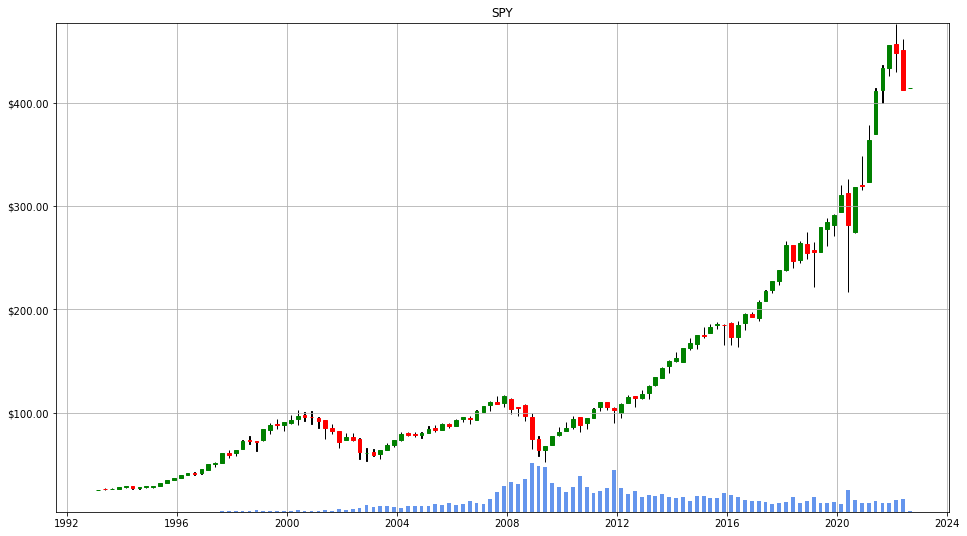

In [8]:
fig, ax = plt.subplots(figsize=(16,9))
    
(df
 .groupby(pd.Grouper(freq = '3m'))
 .agg(Open = ('Adj Close','first'), 
    High = ('Adj Close','max'), 
    Low = ('Adj Close','min'), 
    Close = ('Adj Close','last'),
    Volume = ('Volume','sum'))
 .tail(4*3*100)
 .pipe(candle_plotter, ax)
 )
plt.grid(True)
plt.title(ticker)
#plt.yscale('log')
plt.show()

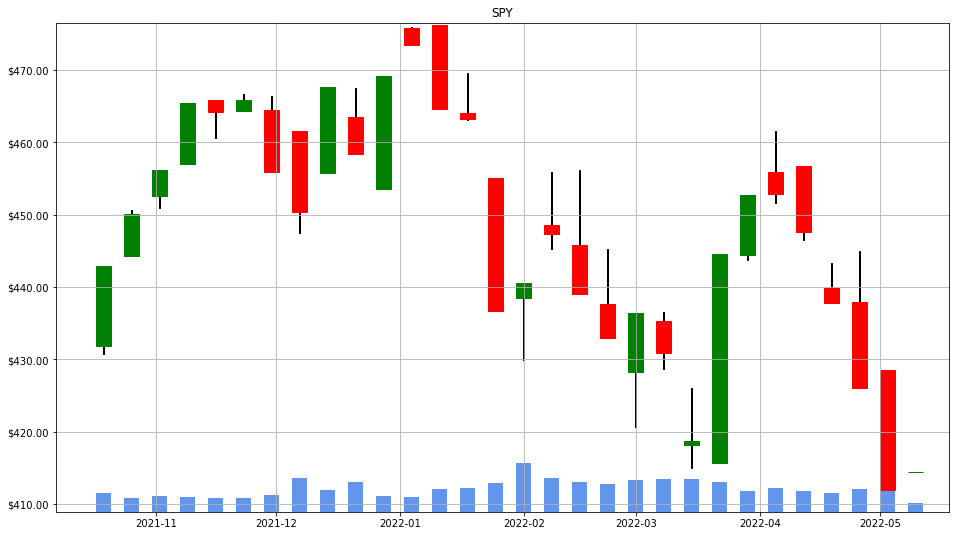

In [9]:
fig, ax = plt.subplots(figsize=(16,9))
(df
 .groupby(pd.Grouper(freq = 'w'))
 .agg(Open = ('Adj Close','first'), 
      High = ('Adj Close','max'), 
      Low = ('Adj Close','min'), 
      Close = ('Adj Close','last'), 
      Volume = ('Volume','sum'))
 .tail(30)
 .pipe(candle_plotter, ax)
)


plt.grid(True)
plt.title(ticker)
#plt.yscale('log')
plt.show()

Using the candlestick plotter for a dataframe with multiple stocks would be tricky since the candles would be overlapping. We will have to settle with a simple lineplot when plotting multiple stocks.

In [10]:
def plotter(df, ser, *args, **kwargs):
    df[ser].plot(*args, **kwargs)
    return df

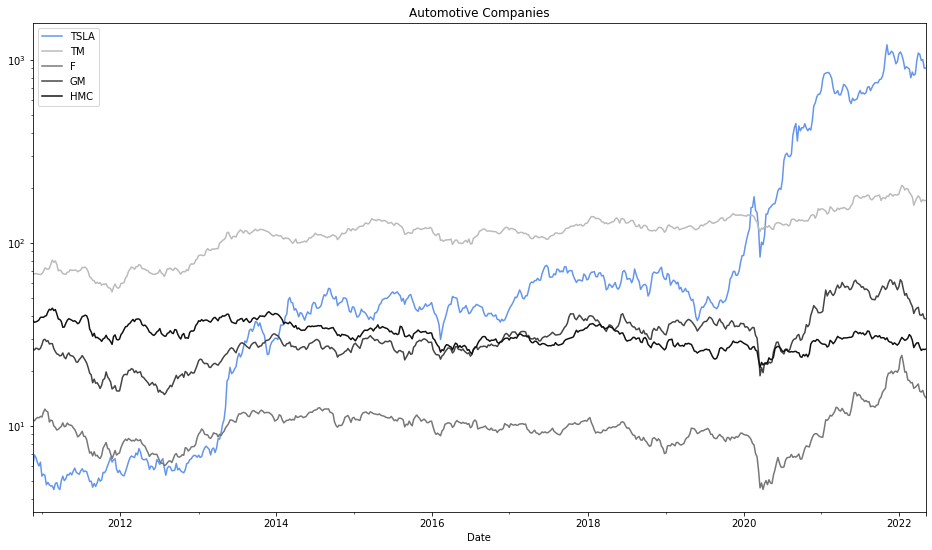

In [11]:
fig, ax = plt.subplots(figsize=(16,9))
(df_m
 .dropna()
 .groupby(pd.Grouper(freq = 'w'))
 .mean()
 .plot(logy=True, 
       ax = ax, color = ['cornflowerblue',
                         '#bbbbbb',
                         '#777777',
                         '#444444',
                         '#111111'])
)
plt.title("Automotive Companies")
plt.show()

# Feature Engineering

## Moving Averages
Some of the most popular indicators for predicting stock prices are moving averages. Moving averages take the last n observations of a stock and average them together. This helps remove some noise from the signal. If a shorter term moving average crosses over a longer term moving average, some believe that the stock has signalled a downturn.
### Simple Weighted Moving Average

The most basic of these moving aveages is the simple moving average. The most commonly used are the 200 day moving average and the 50 day moving average.

We can easily generate those values for the stock of our choice by using the `.rolling()` method in pandas.

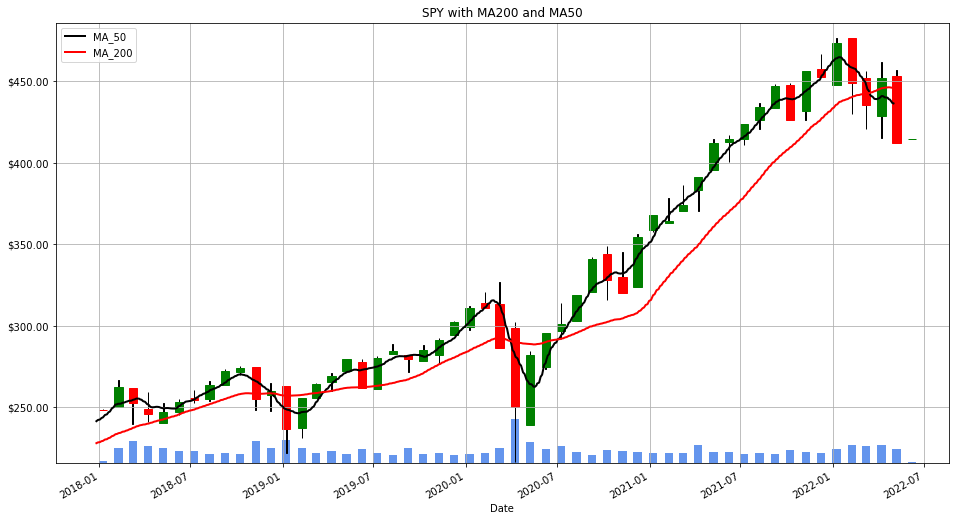

In [12]:
fig, ax = plt.subplots(1, 1,figsize=(16,9))

(df
 .assign(MA_50 = lambda x: x['Adj Close'].rolling(50).mean())
 .assign(MA_200 = lambda x: x['Adj Close'].rolling(200).mean())
 .tail(3*365)
 .pipe(plotter, 'MA_50', color =  'black', linewidth = 2)
 .pipe(plotter, 'MA_200', color = 'red', linewidth = 2 )
 .groupby(pd.Grouper(freq = '1m'))
  .agg(Open = ('Adj Close','first'), 
       High = ('Adj Close','max'), 
       Low = ('Adj Close','min'), 
       Close = ('Adj Close','last'), 
       Volume = ('Volume','sum'))
 .pipe(candle_plotter, ax)
)

plt.title(f"{ticker} with MA200 and MA50")
plt.legend()
plt.grid()
plt.show();

### Exponentially Weighted Moving Average
Exponential moving averages, like simple moving averages, are designed to see price trends over specific time frames. Compared to simple moving averages, EMAs give greater weight to recent data by adding a multiplier to the simple moving average calculation.

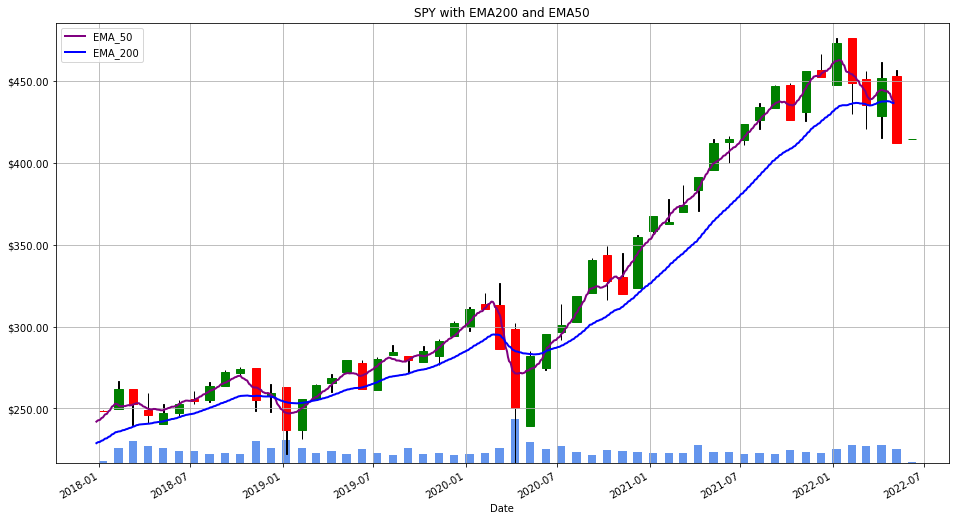

In [13]:
fig, ax = plt.subplots(1, 1,figsize=(16,9))

(df
 .assign(EMA_50 = lambda x: x['Adj Close'].ewm(span = 50).mean())
 .assign(EMA_200 = lambda x: x['Adj Close'].ewm(span = 200).mean())
 .tail(3*365)
 .pipe(plotter, 'EMA_50', color = 'purple', linewidth = 2)
 .pipe(plotter, 'EMA_200', color = 'blue', linewidth = 2)
 .groupby(pd.Grouper(freq = '1m'))
  .agg(Open = ('Adj Close','first'), 
       High = ('Adj Close','max'), 
       Low = ('Adj Close','min'), 
       Close = ('Adj Close','last'), 
       Volume = ('Volume','sum'))
 .pipe(candle_plotter, ax)
)

plt.title(f"{ticker} with EMA200 and EMA50")
plt.legend()
plt.grid()
plt.show();

### Volume Weighted Moving Averages
A volume weighted moving average will weight each record by the volume, so heavier volume days will have more of an impact in the movement of the signal than other days. This typically matches up with the simple moving average with a few exceptions. More recently, Twitter has become a hot stock due to the talks of Elon Musk acquiring the social media site and taking the stock private. This sentiment caused a large spike in volume, which caused the volume weighted price to move much faster than the simple moving average.

In [14]:
def vwap(df, window = 50, q = 'Volume', p = 'Adj Close'):
    q = df[q]
    p = df[p]
    return (p * q).rolling(window=window).sum()/q.rolling(window=window).sum()

In [31]:
twitter = "TWTR"
twitter = load_historical_stock_data(twitter, start = '2020-01-01')

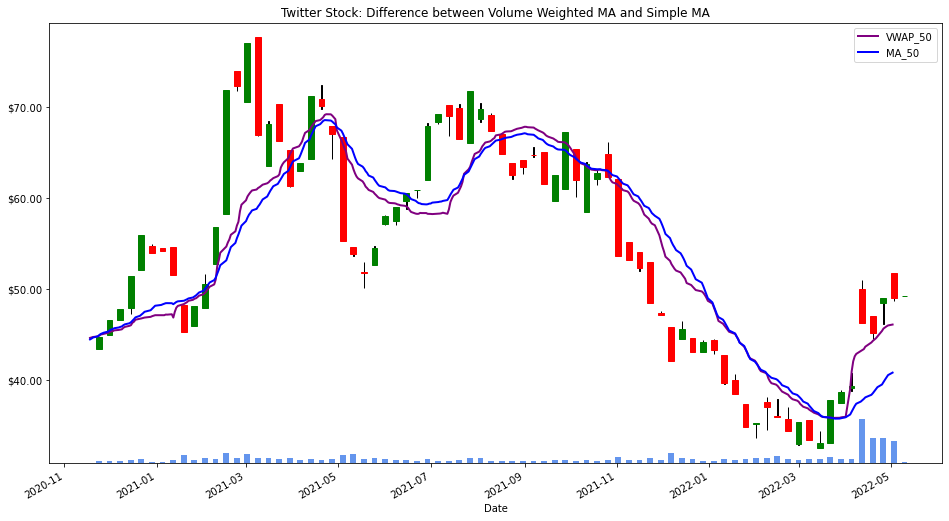

In [32]:
fig, ax = plt.subplots(1, 1,figsize=(16,9))
(twitter
 .assign(VWAP_50 = lambda x: vwap(x))
 .assign(MA_50 = lambda x: x['Adj Close'].rolling(50).mean())
 .tail(365)
 .pipe(plotter, 'VWAP_50', color = 'purple', linewidth = 2)
 .pipe(plotter, 'MA_50', color = 'blue', linewidth = 2)
 .groupby(pd.Grouper(freq = '1w'))
  .agg(Open = ('Adj Close','first'), 
       High = ('Adj Close','max'), 
       Low = ('Adj Close','min'), 
       Close = ('Adj Close','last'), 
       Volume = ('Volume','sum'))
 .pipe(candle_plotter, ax)
)

plt.title("Twitter Stock: Difference between Volume Weighted MA and Simple MA")
plt.legend()
plt.show()

### Jurik Moving Average

In [21]:
def jurik(ser):
    pass

## Oscillators

### MACD
The Moving Average Convergence-Divergence is a value of an exponential moving average (EMA) subtracted from another EMA with a shorter lookback period. Common values are 26 days for the longer EMA and 12 for the shorter. 

In [17]:
def macd_plotter(df, ax):

    ax.plot(df.index, df.Close, alpha = 0)
    start, end = ax.get_xlim()
    candle_width = ((end-start)/len(df))
    for ind, row in df.iterrows():
        
        color = 'green'
        if row['MACD'] < 0:
            color = 'red'
        
        oc_ind = mdates.date2num(ind)
        open_close = patches.Rectangle((oc_ind, 0), 
                                        candle_width,
                                        row['MACD'], 
                                        linewidth=1, 
                                        edgecolor=color, 
                                        facecolor=color,
                                        fill=True)
        
        ax.add_patch(open_close)
    
    ax.set_ylim(df['MACD'].min()*2,df['MACD'].max()*2)
    df['MACD_H'].plot(secondary_y=True, style='black', ax = ax)
    df['MACD_S'].plot(secondary_y=True, style='orange', ax = ax)
    return df

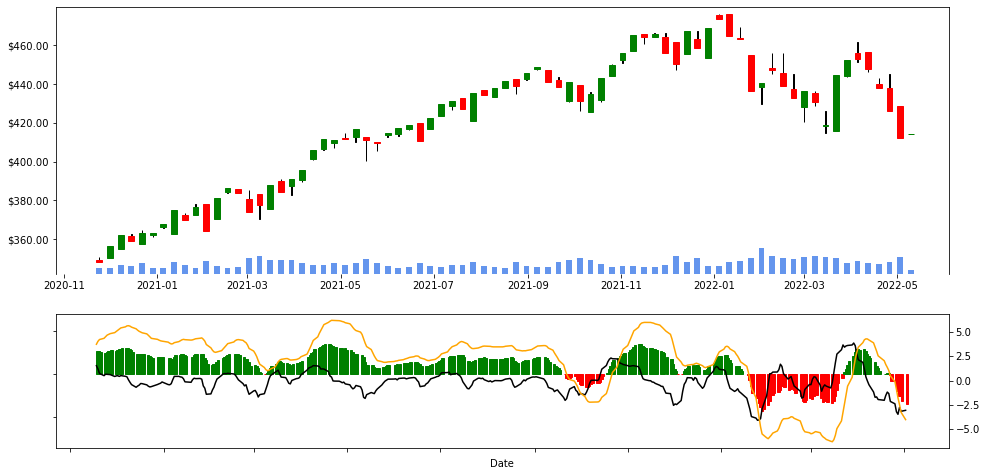

In [46]:
fig, ax = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [2,1]})

(df
 .assign(k = lambda x: x['Adj Close'].ewm(span=12, adjust=False, min_periods=12).mean())
 .assign(d = lambda x: x['Adj Close'].ewm(span=26, adjust=False, min_periods=26).mean())
 .assign(MACD = lambda x: x['k'] - x['d'])
 .assign(MACD_S = lambda x: x['MACD'].ewm(span=9, adjust=False, min_periods=9).mean())
 .assign(MACD_H = lambda x: x['MACD'] - x['MACD_S'])
 .drop(['k','d'], axis = 1)
 .tail(365)
 .pipe(macd_plotter, ax[1])
 .groupby(pd.Grouper(freq = '1w'))
 .agg(Open = ('Adj Close','first'), 
      High = ('Adj Close','max'), 
      Low = ('Adj Close','min'), 
      Close = ('Adj Close','last'), 
      Volume = ('Volume','sum'))
 .pipe(candle_plotter, ax[0])
)
[ax[0].spines[i].set_visible(False) for i in ['bottom']]
[ax[1].spines[i].set_visible(False) for i in ['top','bottom','left','right']]
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
plt.show()

### RSI

The relative strength index, or RSI is a momentum-based indicator used in technical analysis that measures the magnitude of recent price changes to evaluate "overbought" or "oversold" conditions in the price of a stock. RSI is displayed as an oscillator which can have a reading between 0 and 100. The indicator was originally developed by J. Welles Wilder Jr. and introduced in his 1978 book, “New Concepts in Technical Trading Systems.”

The traditional interpretation of the RSI imply that values of 70 or above indicate that a security is becoming "overbought" or "overvalued" and may be primed for a trend reversal or corrective pullback in price. An RSI reading of 30 or below indicates an "oversold" or "undervalued" condition, indicating the opposite.

In [34]:
def rsi(ser, periods = 14, ema = True):
    close_delta = ser.diff()
    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema:
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

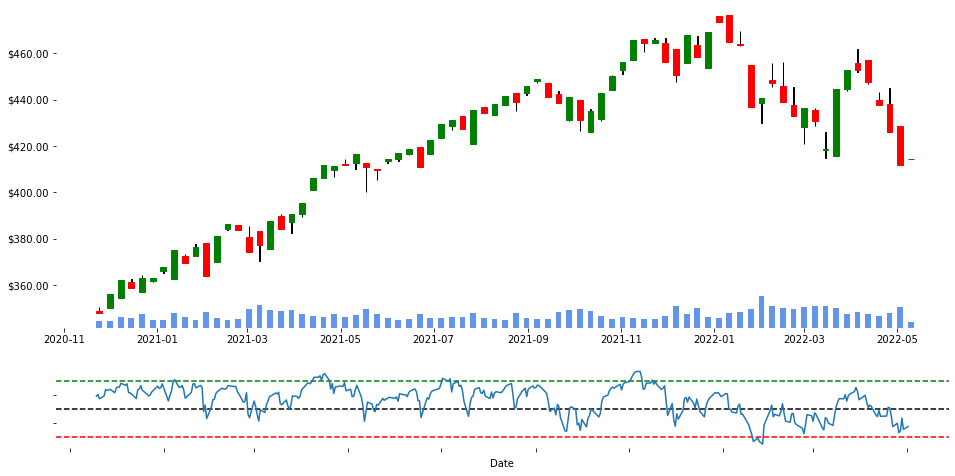

In [43]:
fig, ax = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [4,1]})

(df
 .assign(RSI = lambda x: rsi(x['Adj Close']))
 .tail(365)
 .pipe(lambda x: plotter(x, 'RSI', ax = ax[1]))
  .groupby(pd.Grouper(freq = 'w'))
  .agg(Open = ('Adj Close','first'), 
       High = ('Adj Close','max'), 
       Low = ('Adj Close','min'), 
       Close = ('Adj Close','last'), 
       Volume = ('Volume','sum'))
 .pipe(candle_plotter, ax[0])
)

s,e = ax[1].get_xlim()
ax[1].hlines(y = [30,50,70], 
             xmin = ax[1].get_xlim()[0], 
             xmax = ax[1].get_xlim()[1], 
             linestyle = "--", 
             color = ['red','black','green'])
ax[1].set_xlim(s,e)
[ax[0].spines[i].set_visible(False) for i in ['top','bottom','left','right']]
[ax[1].spines[i].set_visible(False) for i in ['top','bottom','left','right']]
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
plt.show();